In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
from glob import glob
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

K.set_image_data_format('channels_last')

## Building the training dataset.

In [2]:
path = "../input/ultrasound-nerve-segmentation/train/"
file_list = os.listdir(path)
file_list[:20]

['9_12.tif',
 '30_107_mask.tif',
 '19_96_mask.tif',
 '36_63_mask.tif',
 '43_6_mask.tif',
 '29_14_mask.tif',
 '46_42.tif',
 '11_8.tif',
 '8_118_mask.tif',
 '25_16_mask.tif',
 '10_8.tif',
 '23_113_mask.tif',
 '9_57_mask.tif',
 '19_54.tif',
 '35_40_mask.tif',
 '21_49.tif',
 '4_36_mask.tif',
 '42_95.tif',
 '19_68.tif',
 '42_87_mask.tif']

**Sort the file list in ascending order and seperate it into images and masks**<br/>

In [3]:
train_image = []
train_mask = glob(path + '*_mask*')

for i in train_mask:
    train_image.append(i.replace('_mask', ''))
        
print(train_image[:10],"\n" ,train_mask[:10])

['../input/ultrasound-nerve-segmentation/train/30_107.tif', '../input/ultrasound-nerve-segmentation/train/19_96.tif', '../input/ultrasound-nerve-segmentation/train/36_63.tif', '../input/ultrasound-nerve-segmentation/train/43_6.tif', '../input/ultrasound-nerve-segmentation/train/29_14.tif', '../input/ultrasound-nerve-segmentation/train/8_118.tif', '../input/ultrasound-nerve-segmentation/train/25_16.tif', '../input/ultrasound-nerve-segmentation/train/23_113.tif', '../input/ultrasound-nerve-segmentation/train/9_57.tif', '../input/ultrasound-nerve-segmentation/train/35_40.tif'] 
 ['../input/ultrasound-nerve-segmentation/train/30_107_mask.tif', '../input/ultrasound-nerve-segmentation/train/19_96_mask.tif', '../input/ultrasound-nerve-segmentation/train/36_63_mask.tif', '../input/ultrasound-nerve-segmentation/train/43_6_mask.tif', '../input/ultrasound-nerve-segmentation/train/29_14_mask.tif', '../input/ultrasound-nerve-segmentation/train/8_118_mask.tif', '../input/ultrasound-nerve-segmentatio

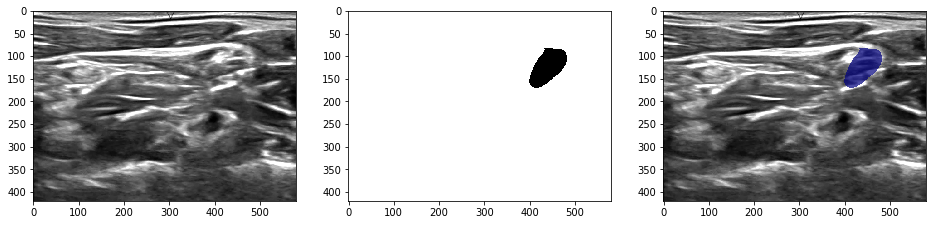

In [4]:
# Display the first image and mask of the first subject.
image1 = np.array(Image.open(path+"1_1.tif"))
image1_mask = np.array(Image.open(path+"1_1_mask.tif"))
image1_mask = np.ma.masked_where(image1_mask == 0, image1_mask)

fig, ax = plt.subplots(1,3,figsize = (16,12))
ax[0].imshow(image1, cmap = 'gray')

ax[1].imshow(image1_mask, cmap = 'gray')

ax[2].imshow(image1, cmap = 'gray', interpolation = 'none')
ax[2].imshow(image1_mask, cmap = 'jet', interpolation = 'none', alpha = 0.7)

Now, we try to load all image files and store them variables X and y.<br/>


## How to deal with train_masks.csv ?

In [5]:
width = 128
height = 128

Let's modularize this work.

In [6]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, UpSampling2D, Lambda, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, add, Reshape
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [7]:
def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [8]:
def segnet(input_size=(512, 512, 1)):

    # Encoding layer
    img_input = Input(input_size)
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((height, width, 1))(x)
    
    return Model(inputs=img_input, outputs=pred)

In [9]:
def train_generator(data_frame, batch_size, train_path, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        directory = train_path,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        directory = train_path,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [10]:
pos_mask = []
pos_img = []
neg_mask = []
neg_img = []

for mask_path, img_path in zip(train_mask, train_image):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if np.sum(mask) == 0:
        neg_mask.append(mask_path)
        neg_img.append(img_path)
    else:
        pos_mask.append(mask_path)
        pos_img.append(img_path)

In [11]:
!mkdir generated
!mkdir generated/img

In [12]:
def flip_up_down(img):
    newImg = img.copy()
    return cv2.flip(newImg, 0)

def flip_right_left(img):
    newImg = img.copy()
    return cv2.flip(newImg, 1)

In [13]:
gen_img = []
gen_mask = []

for (img_path, mask_path) in tqdm(zip(pos_img, pos_mask)):
    image_name = img_path.split('/')[-1].split('.')[0]

    uf_img_path = 'generated/img/'+image_name+'_uf.jpg'
    uf_mask_path = 'generated/img/'+image_name+'_uf_mask.jpg'
    rf_img_path = 'generated/img/'+image_name+'_rf.jpg'
    rf_mask_path = 'generated/img/'+image_name+'_rf_mask.jpg'

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)

    uf_img = flip_up_down(img)
    uf_mask = flip_up_down(mask)
    rf_img = flip_right_left(img)
    rf_mask = flip_right_left(mask)

    cv2.imwrite(uf_img_path, uf_img)
    cv2.imwrite(uf_mask_path, uf_mask)
    cv2.imwrite(rf_img_path, rf_img)
    cv2.imwrite(rf_mask_path, rf_mask)
    
    gen_img.append(uf_img_path)
    gen_mask.append(uf_mask_path)
    gen_img.append(rf_img_path)
    gen_mask.append(rf_mask_path)

2323it [00:40, 55.00it/s]


In [14]:
aug_img = gen_img + train_image
aug_mask = gen_mask + train_mask

df_ = pd.DataFrame(data={"filename": aug_img, 'mask' : aug_mask})
df = df_.sample(frac=1).reset_index(drop=True)

kf = KFold(n_splits = 5, shuffle=False)

In [15]:
histories = []
losses = []
accuracies = []
dicecoefs = []
jacards = []

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

EPOCHS = 115
BATCH_SIZE = 32

for k, (train_index, test_index) in enumerate(kf.split(df)):
    train_data_frame = df.iloc[train_index]
    test_data_frame = df.iloc[test_index]
    
    train_gen = train_generator(train_data_frame, BATCH_SIZE,
                                None,
                                train_generator_args,
                                target_size=(height, width))

    test_gener = train_generator(test_data_frame, BATCH_SIZE,
                                None,
                                dict(),
                                target_size=(height, width))

    model = segnet(input_size=(height,width, 1))
    model.compile(optimizer=Adam(lr=1e-2), loss=dice_coef_loss, \
                      metrics=[jacard, dice_coef, 'binary_accuracy'])

    model_checkpoint = ModelCheckpoint(str(k+1) + '_unet_ner_seg.hdf5', 
                                       verbose=1, 
                                       save_best_only=True)

    history = model.fit_generator(train_gen,
                                  steps_per_epoch=len(train_data_frame) // BATCH_SIZE, 
                                  epochs=EPOCHS, 
                                  callbacks=[model_checkpoint],
                                  validation_data = test_gener,
                                  validation_steps=len(test_data_frame) // BATCH_SIZE)
    
    model = load_model(str(k+1) + '_unet_ner_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'jacard': jacard, 'dice_coef': dice_coef})
    
    test_gen = train_generator(test_data_frame, BATCH_SIZE,
                                None,
                                dict(),
                                target_size=(height, width))
    results = model.evaluate_generator(test_gen, steps=len(test_data_frame) // BATCH_SIZE)
    results = dict(zip(model.metrics_names,results))
    
    histories.append(history)
    accuracies.append(results['binary_accuracy'])
    losses.append(results['loss'])
    dicecoefs.append(results['dice_coef'])
    jacards.append(results['jacard'])
    
    break

Instructions for updating:
Colocations handled automatically by placer.
Found 8224 images.
Found 8224 images.
Epoch 1/115
256/257 [============================>.] - ETA: 0s - loss: -0.1728 - jacard: 0.0971 - dice_coef: 0.1728 - binary_accuracy: 0.8823Found 2057 images.
Found 2057 images.
64/64 [==============================] - 21s 325ms/step - loss: -6.9061e-04 - jacard: 3.4549e-04 - dice_coef: 6.9061e-04 - binary_accuracy: 0.9804

Epoch 00001: val_loss improved from inf to -0.00069, saving model to 1_unet_ner_seg.hdf5
257/257 [==============================] - 137s 534ms/step - loss: -0.1736 - jacard: 0.0977 - dice_coef: 0.1736 - binary_accuracy: 0.8827 - val_loss: -6.9061e-04 - val_jacard: 3.4549e-04 - val_dice_coef: 6.9061e-04 - val_binary_accuracy: 0.9804
Epoch 2/115
64/64 [==============================] - 16s 244ms/step - loss: -0.1927 - jacard: 0.1071 - dice_coef: 0.1927 - binary_accuracy: 0.9580

Epoch 00002: val_loss improved from -0.00069 to -0.19266, saving model to 1_unet_

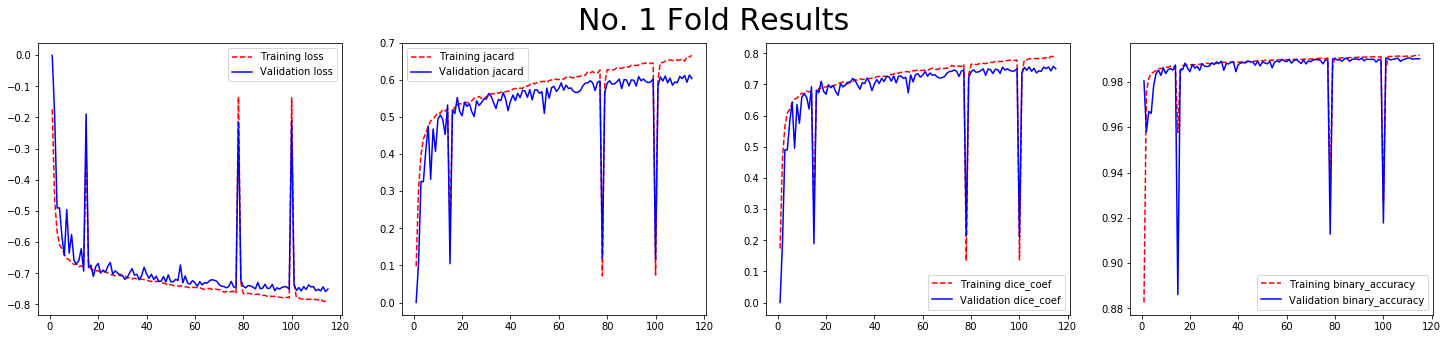

In [16]:
for h, history in enumerate(histories):

    keys = history.history.keys()
    fig, axs = plt.subplots(1, len(keys)//2, figsize = (25, 5))
    fig.suptitle('No. ' + str(h+1) + ' Fold Results', fontsize=30)

    for k, key in enumerate(list(keys)[:len(keys)//2]):
        training = history.history[key]
        validation = history.history['val_' + key]

        epoch_count = range(1, len(training) + 1)

        axs[k].plot(epoch_count, training, 'r--')
        axs[k].plot(epoch_count, validation, 'b-')
        axs[k].legend(['Training ' + key, 'Validation ' + key])

In [17]:
print('average accuracy : ', np.mean(np.array(accuracies)), '+-', np.std(np.array(accuracies)))
print('average loss : ', np.mean(np.array(losses)), '+-', np.std(np.array(losses)))
print('average jacard : ', np.mean(np.array(jacards)), '+-', np.std(np.array(jacards)))
print('average dice_coe : ', np.mean(np.array(dicecoefs)), '+-', np.std(np.array(dicecoefs)))

average accuracy :  0.99029064 +- 0.0
average loss :  -0.7607215018942952 +- 0.0
average jacard :  0.6152688 +- 0.0
average dice_coe :  0.7607215 +- 0.0


In [18]:
model = load_model('1_unet_ner_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'jacard': jacard, 'dice_coef': dice_coef})

1 15


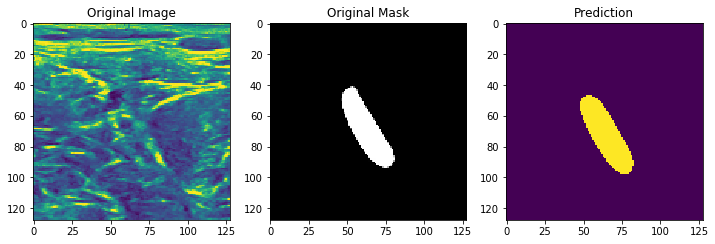

2 1822


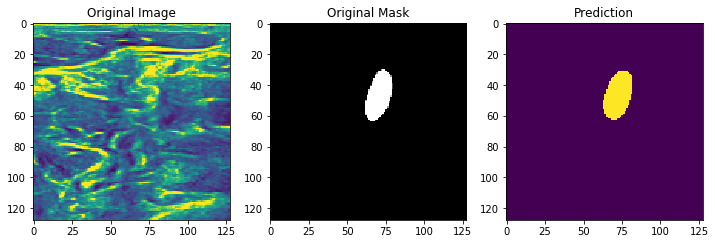

3 286


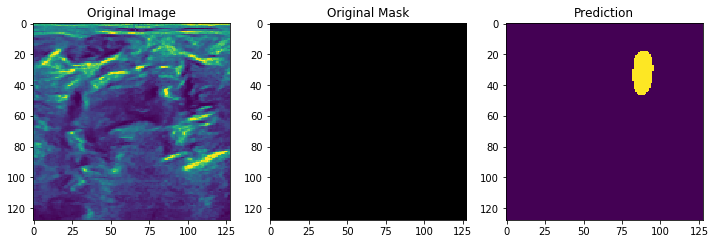

4 1953


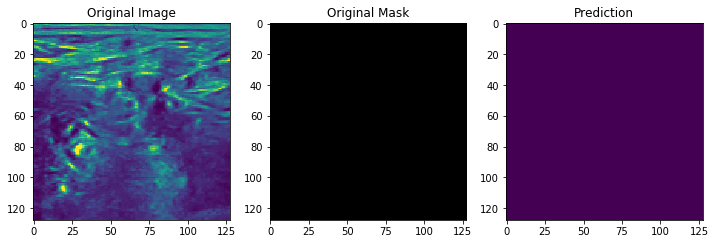

5 1821


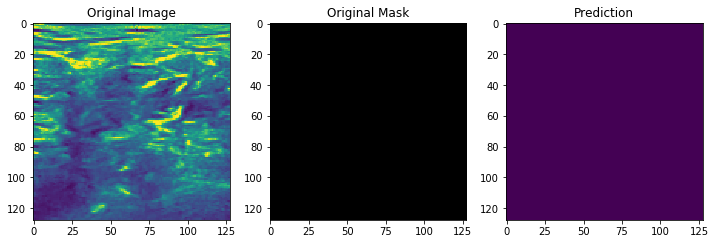

6 894


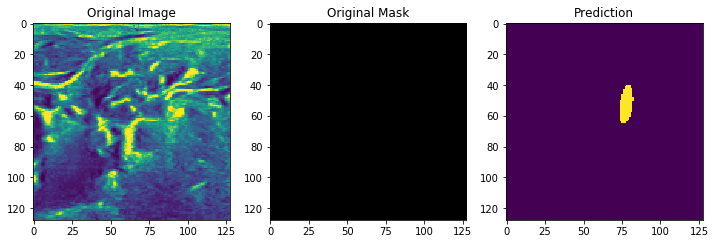

7 475


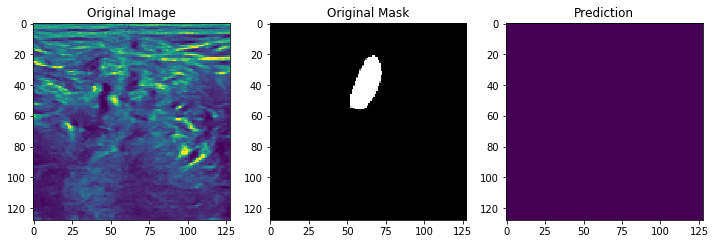

8 1659


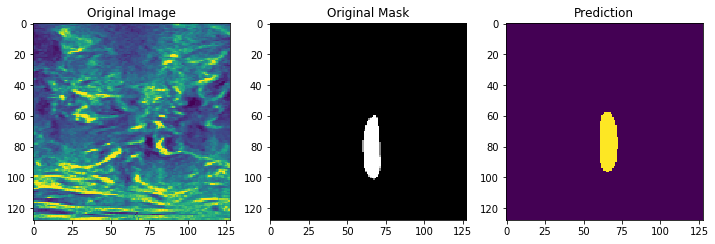

9 883


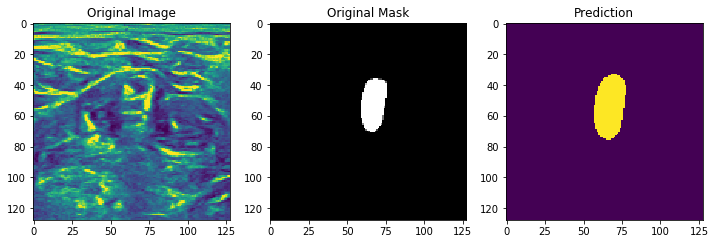

10 1377


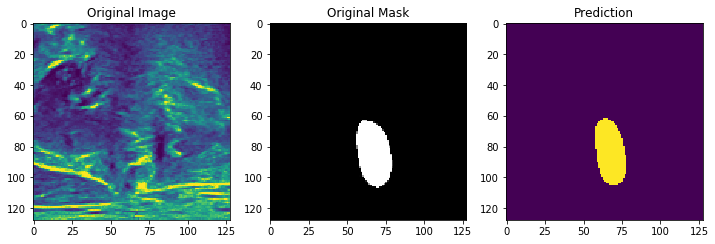

11 71


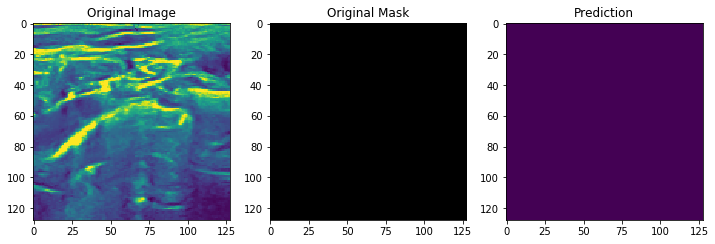

12 1271


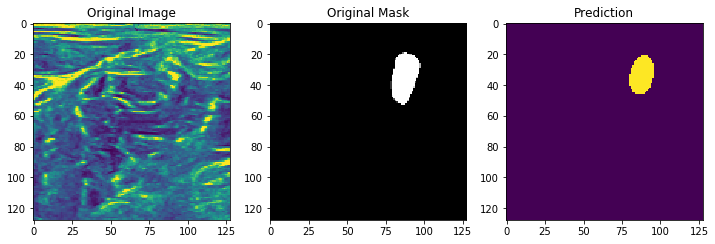

13 194


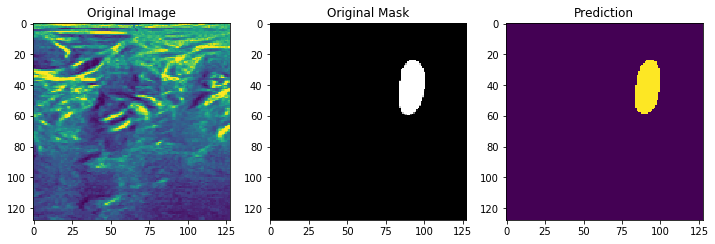

14 1845


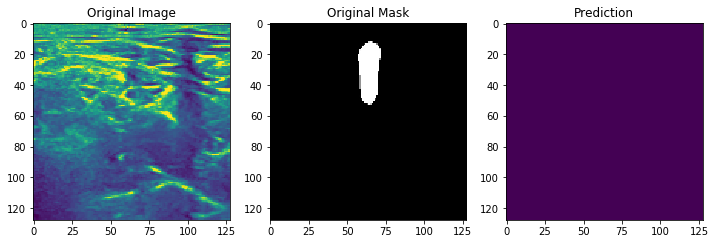

15 1576


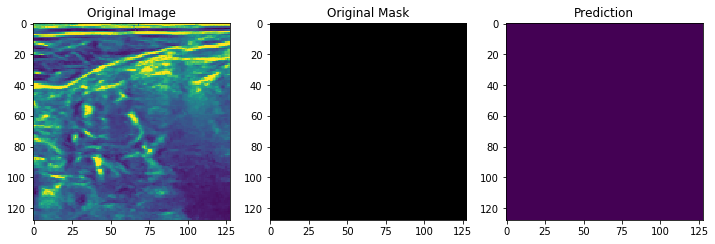

16 1403


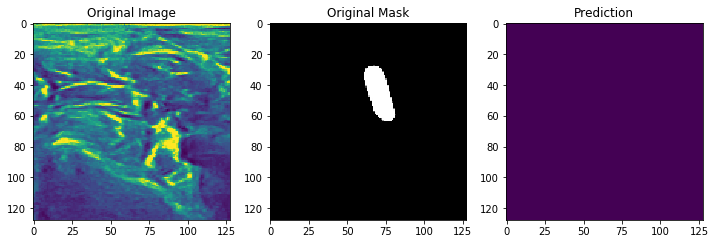

17 914


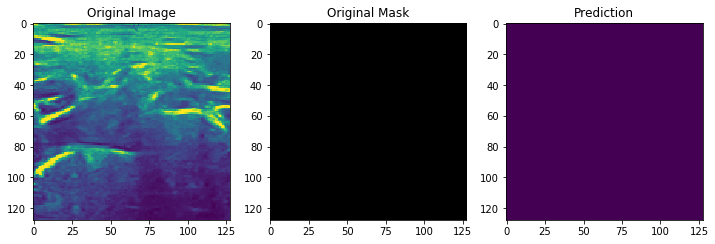

18 340


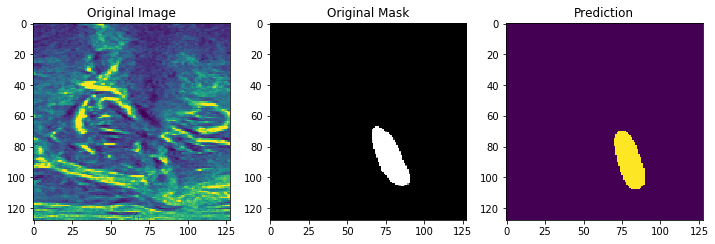

19 962


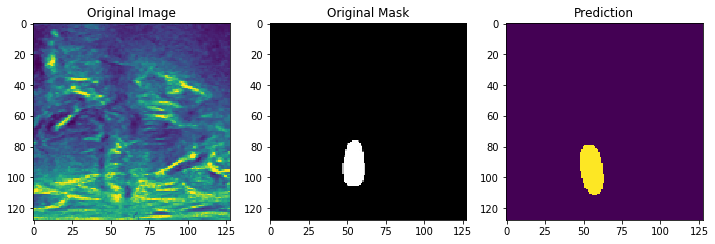

20 1965


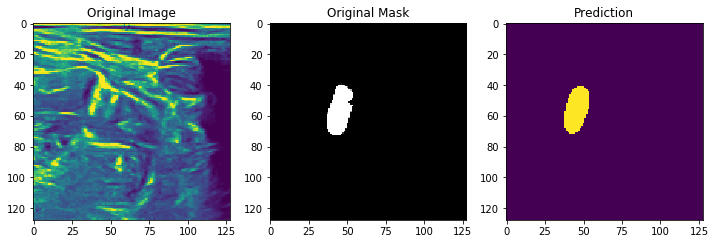

In [19]:
for i in range(20):
    index=np.random.randint(0,len(test_data_frame.index))
    print(i+1, index)
    img = cv2.imread(test_data_frame['filename'].iloc[index], cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (height, width))
    img = img[np.newaxis, :, :, np.newaxis]
    img = img / 255
    pred = model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.resize(cv2.imread(test_data_frame['mask'].iloc[index]), (height, width))))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

In [20]:
!rm -r generated                                                                          